In [30]:
import time
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.cluster import MiniBatchKMeans
from skimage.util import view_as_windows
from tqdm import trange
from tqdm import tqdm

In [23]:
def to_windows(img,window_shape,step_shape,dims=None):
    pad = []
    if dims is None : dims = img.ndim
    for i in range(img.ndim):
        if i < dims:
            n = img.shape[i]
            s = step_shape[i]
            f = window_shape[i]
            p = int((f + (n - 1)*s - n)/2)
        else:
            p = 0
        pad.append((p,p))
    img_padded = np.pad(img, tuple(pad), 'constant', constant_values=(0))
    output = view_as_windows(img_padded,window_shape,step_shape)
    output = output.reshape( -1, np.prod( window_shape ) )
    return output

def H(x):
    y = np.zeros(x.shape) 
    y[x>0] = 1
    return y

def regular_convolution(x,K):
    kernel_shape = K.shape
    step_shape = tuple(np.ones(len(kernel_shape)).astype(int))
    data = to_windows(x,kernel_shape,step_shape)
    W = K.reshape(1,-1)
    logits = data @ W.T
    return logits.reshape(x.shape)

def cosine_convolution(x,K,wta=True):    
    k = K.shape[0]
    kernel_shape = K.shape[1:]
    step_shape = tuple(np.ones(len(kernel_shape)).astype(int))
    data = to_windows(x,kernel_shape,step_shape)
    norms = np.linalg.norm(data,axis=1,keepdims=True)
    out = (norms<=0)[:,0]
    norms[out] = 1
    data = data / norms
    W = K.reshape(k,-1)
    norms = np.linalg.norm(W,axis=1,keepdims=True)
    W = W / norms
    d = ((data @ W.T) + 1)/2
    if wta:
        t = d.max(axis=1,keepdims=True)
        t[np.linalg.norm(data,axis=1)<=0] = np.inf
        o = np.zeros(d.shape)
        o[(t-d)<=0] = d[(t-d)<=0]
        o = o.reshape(x.shape + (k,))
        return o
    return d.reshape(x.shape + (k,))

def euclid_convolution(x,km,wta=True):    
    k = km.cluster_centers_.shape[0]
    kernel_shape = int(np.sqrt(km.cluster_centers_.shape[1]))
    kernel_shape = (kernel_shape,kernel_shape)
    step_shape = tuple(np.ones(len(kernel_shape)).astype(int))
    data = to_windows(x,kernel_shape,step_shape)
    d = 1/km.transform(data)
    if wta:
        t = d.max(axis=1,keepdims=True)
        t[np.linalg.norm(data,axis=1)<=0] = np.inf
        o = np.zeros(d.shape)
        o[(t-d)<=0] = d[(t-d)<=0]
        o = o.reshape(x.shape + (k,))
        return o
    return d.reshape(x.shape + (k,))

def mu_ret(img,K,T_ret,wta=True):
    #z = cosine_convolution(img,K,wta=wta)
    z = euclid_convolution(img,K,wta=wta)
    a = H(z - np.quantile(z[z>0],q=T_ret))
    return a

def enum_set(a):
    n_H, n_W, n_K = a.shape
    k = np.linspace(1, n_K, n_K)
    h = np.flip(np.linspace(0, n_H-1, n_H))
    w = np.linspace(0, n_W-1, n_W)
    W, H, K = np.meshgrid(w, h, k)
    k = K[a!=0]
    h = H[a!=0]
    w = W[a!=0]
    ret_set = np.zeros((k.shape[0],3))
    ret_set[:,0] = ((w/(n_W-1))*2)-1
    ret_set[:,1] = ((h/(n_H-1))*2)-1
    ret_set[:,2] = k
    return ret_set

def translation(features,C_x,C_y):
    M = np.eye(3)
    M[0:-1,-1] = (C_x,C_y)
    pos = np.copy(features)
    pos[:,-1] = 1
    pos = np.dot(M,pos.T).T
    pos[:,-1] = features[:,-1]
    return pos

def scale(features,rad):
    pos = np.copy(features)
    M = np.diag([1./rad,1./rad])
    pos[:,0:2] = np.dot(M,pos[:,0:2].T).T
    return pos

def polar_transform(x):
    cx,cy = np.mean(x[:,0:2],axis=0)
    w = x[:,0]
    h = x[:,1]
    rad = np.max(np.sqrt((w - cx)**2 + (h - cy)**2))
    pol = scale(translation(x,-cx,-cy),rad)
    params = (np.array([cx,cy]),rad)
    return pol, params

Exception ignored in: <function tqdm.__del__ at 0x7fcce0958950>
Traceback (most recent call last):
  File "/home/rsimas/miniconda3/envs/torch/lib/python3.7/site-packages/tqdm/std.py", line 1147, in __del__
    self.close()
  File "/home/rsimas/miniconda3/envs/torch/lib/python3.7/site-packages/tqdm/notebook.py", line 286, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


In [24]:
def grid_encoding(x,Q,k):
    pol = np.zeros(x.shape)
    pol[:,0] = x[:,1]
    pol[:,1] = x[:,0]
    pol[:,2] = x[:,2]
    h = np.histogramdd(pol, bins=(Q,Q,k), range=[(-1,1),(-1,1),(1,k)])[0]
    h = np.flip(h,axis=0) # for visualization purposes
    h[h>0] = 1
    return h

In [41]:
def learn_dictionary(D,k,patch_size,rng,n_epochs,background=0.8,kmeans=None):
    if kmeans is None:
        kmeans = MiniBatchKMeans(n_clusters=k, random_state=rng, verbose=True)
    buffer = []

    index = 0
    for _ in trange(n_epochs, desc="Learning the dictionary", unit="epoch"):
        for img in tqdm(D, unit="datasample", leave=False):
            data = to_windows(img,patch_size,tuple(np.ones(len(patch_size)).astype(int)))
            norms = np.linalg.norm(data,axis=1,keepdims=True)
            keep = norms>background
            keep = keep[:,0]
            data = data[keep,:]
            #norms = norms[keep,:]
            #data = data / norms
            data = np.reshape(data, (len(data), -1))
            buffer.append(data)
            index += 1
            if index % 10 == 0:
                data = np.concatenate(buffer, axis=0)
                data -= np.mean(data, axis=0)
                data /= np.std(data, axis=0)
                kmeans.partial_fit(data)
                buffer = []

    return kmeans.cluster_centers_.reshape((-1,) + patch_size),kmeans

In [42]:
def reconstruct(x,K):
    reconstruction_kernels = np.flip(np.flip(K,axis=2),axis=1)
    reconstruction_kernels = np.moveaxis(reconstruction_kernels,(0,1,2),(2,0,1))
    Q,_,k = x.shape
    f,_,_ = reconstruction_kernels.shape
    p = f//2
    x_windows = np.squeeze(view_as_windows(np.pad(x,((p,p),(p,p),(0,0))),(f,f,k),(1,1,k)))
    x_contributions = x_windows * reconstruction_kernels
    weight = x_windows.reshape(Q,Q,-1).sum(axis=-1)
    weight[weight==0] = 1
    vals = x_contributions.reshape(Q,Q,-1).sum(axis=-1)
    r = vals / weight
    r[r<0]=0
    return r

def reconstruct_slow(x,K):
    k,f,_ = K.shape
    p = f // 2
    x_padded = np.pad(x,((p,p),(p,p),(0,0)))
    x_padded.shape
    r = np.zeros((Q,Q))
    for i in range(Q):
        for j in range(Q):
            i_pad = i+p
            j_pad = j+p
            count = 0
            pixel = 0
            for m in np.arange(-p,p+1):
                for n in np.arange(-p,p+1):
                    pos_i = i_pad + m
                    pos_j = j_pad + n
                    k_i = f - (m+p) - 1
                    k_j = f - (n+p) - 1
                    for l in range(k):
                        # if this kernel contributes added the corresponding pixel
                        if x_padded[pos_i,pos_j,l] > 0:
                            count += 1
                            pixel += K[l,k_i,k_j]
            if count > 0:
                r[i,j] = pixel / count
    r[r<0] = 0
    return r

################################################################################

#            Reversão do pipeline, NÃO MUITO BEM TESTADA, AVISO JÁ

################################################################################

def ungrid(a):
    Q, Q, n_K = a.shape
    k = np.linspace(1, n_K, n_K)
    h = np.flip(np.linspace(-1, 1, Q))
    w = np.linspace(-1, 1, Q)
    W, H, K = np.meshgrid(w, h, k)
    k = K[a!=0]
    h = H[a!=0]
    w = W[a!=0]
    as_set = np.zeros((k.shape[0],3))
    as_set[:,0] = w
    as_set[:,1] = h
    as_set[:,2] = k
    return as_set

def unpolar(pol,params):
    C,rad = params
    cx,cy = C
    ret = translation(scale(pol,1./rad),cx,cy)
    return ret

def unenum(ret):
    ret_set = np.zeros((ret.shape[0],3))
    ret_set[:,0] = ((ret[:,1] + 1)/2) * (n_W-1)
    ret_set[:,1] = ((ret[:,0] + 1)/2) * (n_H-1)
    ret_set[:,2] = ret[:,2]
    h = np.histogramdd(ret_set, bins=(n_H,n_W,k), range=[(0,n_H-1),(0,n_W-1),(1,k)])[0]
    h = np.flip(h,axis=0) # for visualization purposes
    h[h>0] = 1
    return h

Shape: (60000, 28, 28)
Example: 


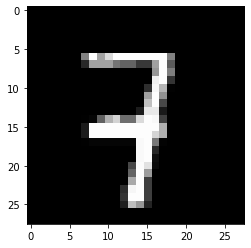

In [43]:
mnist = tf.keras.datasets.mnist
(X_train, y_D),(X_test, y_T) = mnist.load_data()
D, T = X_train / 255.0, X_test / 255.0

n_train = D.shape[0]
n_test = T.shape[0]
n_H = D.shape[1]
n_W = D.shape[2]
n_classes = 10

print("Shape: " + str(D.shape))
print("Example: ")
plt.imshow(D[np.random.permutation(D.shape[0])[0]],cmap="gray")
plt.show()

In [44]:
n_epochs = 5
k = 30
f = 5
kernel_shape = (f,f)
rng = np.random.RandomState(0)
T_what = 0.6
T_where = 0.165
Q = 18

In [45]:
K,km = learn_dictionary(D,k,kernel_shape,rng,n_epochs,background=0.8)

Learning the dictionary:   0%|          | 0/5 [00:14<?, ?epoch/s]


KeyboardInterrupt: 

In [46]:
X_trn = np.zeros((D.shape[0],Q,Q,k))
polar_params = []
for i in trange(D.shape[0]):
    img = D[i]
    a = mu_ret(img,km,T_what,wta=True)
    s = enum_set(a)
    p,params = polar_transform(s)
    polar_params.append(params)
    X_trn[i] = grid_encoding(p,Q,K.shape[0])

100%|██████████| 60000/60000 [03:56<00:00, 253.83it/s]


### Reconstrução

In [47]:
i = 12
img = D[i]
encoding = X_trn[i]
params = polar_params[i]

##### Versão QxQ

<Figure size 432x288 with 0 Axes>

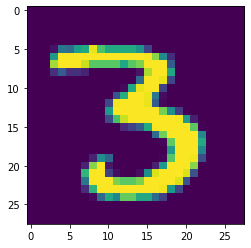

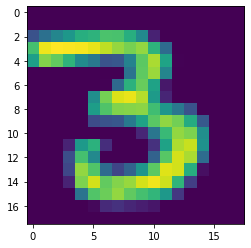

<Figure size 432x288 with 0 Axes>

In [48]:
recon = reconstruct(encoding,K)

plt.imshow(img)
plt.figure()
plt.imshow(recon)
plt.figure()

##### Versão 28x28

In [49]:
pol = ungrid(encoding)
ret = unpolar(pol,params)
h = unenum(ret)
recon = reconstruct(h,K)

<Figure size 432x288 with 0 Axes>

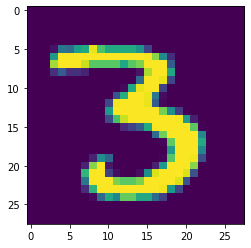

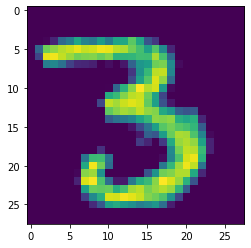

<Figure size 432x288 with 0 Axes>

In [50]:
plt.imshow(img)
plt.figure()
plt.imshow(recon)
plt.figure()